In [1]:
#basic imports and ipython setup
%load_ext autoreload
%autoreload 2
import os
from scipy.interpolate import interp1d
from scipy.integrate import trapz
from collections import OrderedDict

import numpy as np
os.chdir('..')

#import solver related modules
from MCEq.core import MCEqRun
from mceq_config import config
#import primary model choices
import CRFluxModels as pm

In [14]:
interaction_models = (
    'EPOS-LHC',
    'QGSJet-II-04',
    'QGSJet-II-03',
    'SIBYLL-2.3.5',
    'SIBYLL-2.1',
    'QGSJet01',
)

# E0, h_obs, theta_deg, density_model
experiments = {
    "auger": (1e10, 1425, 67, ("CORSIKA", ("BK_USStd", None))),
    "icecube": (1e8, 2835, 13, ("MSIS00_IC", ("SouthPole", "January"))),
    "felix1": (2e6, 0, 60, ("CORSIKA", ("BK_USStd", None))),
    "felix2": (2e10, 0, 60, ("CORSIKA", ("BK_USStd", None))),
}

lepton_spectra = {}

In [15]:
for experiment in experiments:
    if experiment not in lepton_spectra:
        lepton_spectra[experiment] = {}
    for interaction_model in interaction_models:
        if interaction_model in lepton_spectra[experiment]:
            print "skipping", interaction_model
            continue
        lepton_spectra[experiment][interaction_model] = {}
        for prim in ("proton", "iron"):
            print "=== processing", experiment, interaction_model, prim, "==="
            spectra = lepton_spectra[experiment][interaction_model][prim] = {}

            cr_energy, h_obs, theta_deg, density_model = experiments[experiment]
            
            cfg = dict(config)
            cfg["density_model"] = density_model
            cfg["h_obs"] = h_obs
            mceq_run = MCEqRun(
                interaction_model,
                primary_model=(pm.HillasGaisser2012, 'H3a'),
                theta_deg=theta_deg,
                **cfg
            )

            a = {"proton": 1, "iron": 56}[prim]
            mceq_run.set_single_primary_particle(
                cr_energy,
                {"proton": 14, "iron": 5626}[prim]
            )

            Xvec = np.arange(1, mceq_run.density_model.max_X, 5)
            idx = np.argmin(np.abs(Xvec - 1000)) # idx for 1000 gcm-2

            mceq_run.solve(int_grid=Xvec, grid_var="X")

            spectra["egrid"] = mceq_run.e_grid
            for t in ("total", "conv", "pr"):
                if experiment.startswith("felix"):
                    spectra["mu_" + t] = (
                        mceq_run.get_solution(t + '_mu+', grid_idx=idx) +
                        mceq_run.get_solution(t + '_mu-', grid_idx=idx)
                    )
                else:
                    spectra["mu_" + t] = (
                        mceq_run.get_solution(t + '_mu+') +
                        mceq_run.get_solution(t + '_mu-')
                    )


=== processing auger EPOS-LHC proton ===
InteractionYields::_load(): Looking for /Users/hdembins/miniconda2/MCEq/data/EPOSLHC_yields_compact_ledpm.bz2
DecayYields:_load():: Loading file /Users/hdembins/miniconda2/MCEq/data/decays_v1_compact.ppd

Hadrons and stable particles:

"gamma", "p", "p-bar", "n", "n-bar"

Mixed:

"pi-", "pi+", "K0L", "K-", "K+", "Lambda0", "Lambda0-bar", "K0S"

Resonances:



Leptons:

"e-", "nue", "numu", "nutau", "antinutau", "antinumu", "antinue", "e+", 
"mu-", "mu+"

Aliases:
"obs_numu", "obs_nutau", "pr_antinutau", "pr_antinumu", "pr_antinue", "obs_antinue", "k_nue", "k_numu", 
"k_nutau", "pi_antinutau", "pi_antinue", "pi_antinumu", "pi_nue", "pi_numu", "pi_nutau", "k_antinutau", 
"k_antinumu", "k_antinue", "obs_nue", "pr_nue", "pr_numu", "pr_nutau", "obs_antinutau", "obs_antinumu", 
"k_mu-", "obs_mu-", "pr_mu+", "pi_mu+", "pi_mu-", "pr_mu-", "obs_mu+", "k_mu+"

Total number of species: 55
MCEqRun::set_interaction_model():  EPOSLHC
InteractionYields:set_int

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.size"] = 20
rcParams["figure.figsize"] = (7, 6)

def model_color(name):
    model_colors = {"EPOS-LHC": "g",
                    "SIBYLL-2.3": "r",
                    "SIBYLL-2.1": "b", 
                    "QGSJet-II-04" : "m"}
    for k,v in model_colors.items():
        if name.startswith(k):
            return v


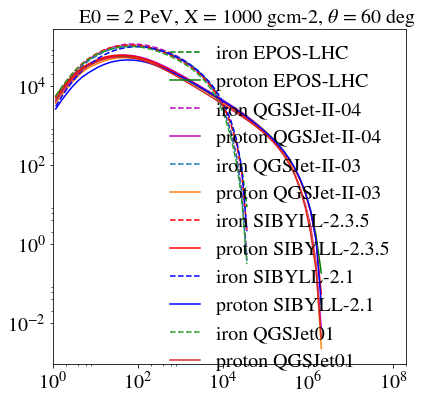

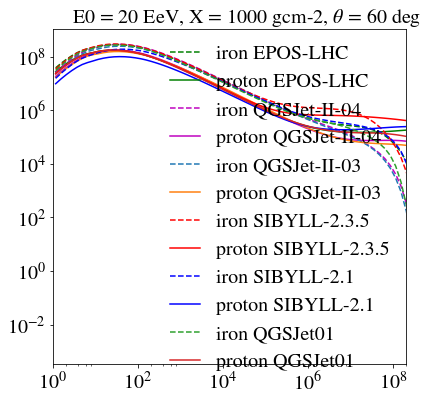

In [18]:
# muon spectra 1
for experiment in ("felix1", "felix2"):
    plt.figure()
    for interaction_model in interaction_models:
        if interaction_model not in lepton_spectra[experiment]:
            continue
        prim_spectra = lepton_spectra[experiment][interaction_model]

        plt.title({
            "felix1": r"E0 = 2 PeV, X = 1000 gcm-2, $\theta$ = 60 deg",
            "felix2": r"E0 = 20 EeV, X = 1000 gcm-2, $\theta$ = 60 deg",
        }[experiment], x=0.55)
        for prim, spectra in prim_spectra.items():
            x = spectra["egrid"]
            y = spectra["mu_total"]
            label = {"proton" : "p", "iron": "Fe"}[prim]
            plt.plot(x, y * x ** 2, "-" if prim == "proton" else "--",
                     color=model_color(interaction_model),
                     label=prim + " " + interaction_model)
        plt.loglog()
        plt.xlim(1, 2e4 if experiment == "icecube" else 2e8)
        plt.legend()


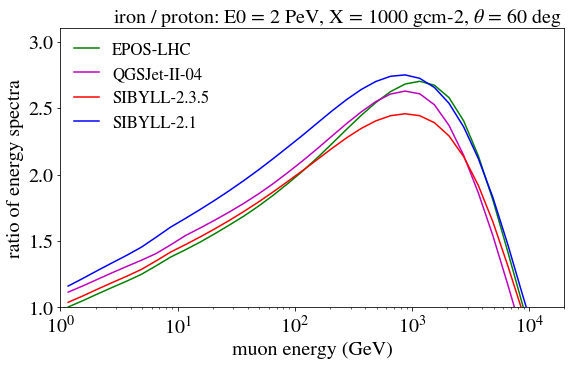

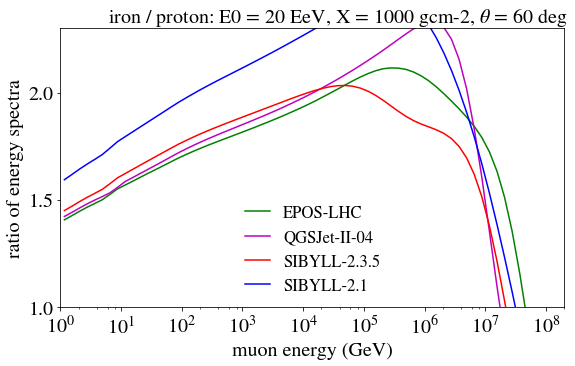

In [19]:
# muon spectra ratio
for experiment in ("felix1", "felix2"):
    plt.figure(figsize=(10, 5))
    for interaction_model in ("EPOS-LHC", "QGSJet-II-04", "SIBYLL-2.3.5", "SIBYLL-2.1"):
        if interaction_model not in lepton_spectra[experiment]:
            continue
        prim_spectra = lepton_spectra[experiment][interaction_model]

        plt.title("iron / proton: " + {
            "felix1": r"E0 = 2 PeV, X = 1000 gcm-2, $\theta$ = 60 deg",
            "felix2": r"E0 = 20 EeV, X = 1000 gcm-2, $\theta$ = 60 deg",
        }[experiment], x=0.55)
        
        x = prim_spectra["proton"]["egrid"]
        with np.errstate(invalid="ignore"):
            y = prim_spectra["iron"]["mu_total"] / prim_spectra["proton"]["mu_total"]
        plt.plot(x, y, "-",
                 color=model_color(interaction_model),
                 label=interaction_model)
        plt.semilogx()
        if experiment == "felix1":
            plt.xticks(10 ** np.arange(0, 5))
            plt.yticks((1.0, 1.5, 2.0, 2.5, 3.0))
            plt.xlim(1, 2e4)
            plt.ylim(1, 3.1)
        else:
            plt.xlim(1, 2e8)
            plt.ylim(1, 2.3)
            plt.xticks(10 ** np.arange(0, 9))
            plt.yticks((1, 1.5, 2.0))
        plt.xlabel("muon energy (GeV)")
        plt.ylabel("ratio of energy spectra")
        plt.legend(fontsize="small")
        plt.savefig({"felix1": "two_pev.pdf", "felix2": "two_eev.pdf"}[experiment])


In [20]:
# comparion with Auger PRD 2015 paper: total number of muons at ground
rmu_unit = 1.455e7 # muons with Emu > 0.3 GeV for theta = 67 deg
lnrmu = OrderedDict()
increase = []
print "number of muons at ground for auger"
for interaction_model in interaction_models:
    if interaction_model not in lepton_spectra["auger"]:
        continue
    prim_spectra = lepton_spectra["auger"][interaction_model]

    for prim, spectra in prim_spectra.items():
        x = spectra["egrid"]
        y = spectra["mu_total"]
        nmu1 = np.trapz(y, x)
        x1 = np.append([0.3], x)
        y1 = np.append(y[0], y)
        nmu2 = np.trapz(y1, x1)
        increase.append(nmu2 / nmu1)
        print interaction_model, prim, "%.3f x 1e7" % (nmu2 / 1e7)
        lnrmu[(interaction_model, prim)] = np.log(nmu2 / rmu_unit)
print "average increase from lowering threshold", np.mean(increase)
print "lnRmu like in Auger Paper:"
for y, key in enumerate(lnrmu.keys()):
    model, prim = key
    x = lnrmu[key]
    print "%19s %2s %6.3f" % (model, {"proton":"p", "iron":"Fe"}[prim], x)


number of muons at ground for auger
EPOS-LHC iron 2.174 x 1e7
EPOS-LHC proton 1.471 x 1e7
QGSJet-II-04 iron 1.998 x 1e7
QGSJet-II-04 proton 1.320 x 1e7
QGSJet-II-03 iron 1.716 x 1e7
QGSJet-II-03 proton 1.158 x 1e7
SIBYLL-2.3.5 iron 2.217 x 1e7
SIBYLL-2.3.5 proton 1.446 x 1e7
SIBYLL-2.1 iron 1.233 x 1e7
SIBYLL-2.1 proton 0.708 x 1e7
QGSJet01 iron 1.946 x 1e7
QGSJet01 proton 1.336 x 1e7
average increase from lowering threshold 1.05743074224
lnRmu like in Auger Paper:
           EPOS-LHC Fe  0.401
           EPOS-LHC  p  0.011
       QGSJet-II-04 Fe  0.317
       QGSJet-II-04  p -0.097
       QGSJet-II-03 Fe  0.165
       QGSJet-II-03  p -0.229
       SIBYLL-2.3.5 Fe  0.421
       SIBYLL-2.3.5  p -0.006
         SIBYLL-2.1 Fe -0.165
         SIBYLL-2.1  p -0.720
           QGSJet01 Fe  0.291
           QGSJet01  p -0.086
